# **TP2 - Vision Transformers (ViT)**

# **Florentino Arias (a1719)**

## **Especialización en Inteligencia Artificial FIUBA 2b2025 - Visión por Computadora III**

## Tareas:

1. **Implementar la arquitectura de un Vision Transformer**

2. **Ingresar y ajustar los parámetros del modelo**

3. **Probar diferentes técnicas de data augmentation**

In [1]:
from google.colab import files
uploaded = files.upload()  # Permite subir trainer.py

Saving trainer.py to trainer.py


In [2]:
# IMPORTACIONES
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from trainer import Trainer, EarlyStopping

In [3]:
# PREPARACIÓN DE DATOS: CIFAR-10 + Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

100%|██████████| 170M/170M [00:02<00:00, 76.7MB/s]


In [6]:
import os
import math
def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"


folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

Tamaño de carpeta: 340.19 MB


In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [8]:
# DEFINICIÓN DE CLASES DEL MODELO
class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncodingLearned(nn.Module): # CÓDIGO IMPLEMENTADO EN EL TP1
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        return x + self.pos_embedding

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout, bias=False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)

class VisionTransformer(nn.Module): # Pongo los parámetros en el init
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=128, depth=6, num_heads=4, mlp_dim=256, dropout=0.1):
        super(VisionTransformer, self).__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.pos_embed = PositionalEncodingLearned(self.patch_embed.num_patches, embed_dim)
        self.transformer = TransformerEncoder(embed_dim, num_heads, mlp_dim, depth, dropout)
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.pos_embed(x)
        x = self.transformer(x)
        x = self.norm(x)
        x = x.mean(dim=1)  # Pooling por promedio
        x = self.head(x)
        return x

In [9]:
# FUNCIONES MIXUP Y CUTMIX
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size, _, H, W = x.size()
    index = torch.randperm(batch_size).to(x.device)

    cx = np.random.randint(W)
    cy = np.random.randint(H)
    w = int(W * np.sqrt(1 - lam))
    h = int(H * np.sqrt(1 - lam))

    x1 = np.clip(cx - w // 2, 0, W)
    x2 = np.clip(cx + w // 2, 0, W)
    y1 = np.clip(cy - h // 2, 0, H)
    y2 = np.clip(cy + h // 2, 0, H)

    x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]
    y_a, y_b = y, y[index]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
    return x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

Dispositivo:  cuda
Torch version:  2.6.0+cu124


In [11]:
# INSTANCIAR MODELO, OPTIMIZADOR, LOSS
model = VisionTransformer().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

print("Parametros del modelo:", list(model.parameters()))

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[[ 0.0111,  0.0627, -0.0526, -0.1334],
          [ 0.0564,  0.1331, -0.0644,  0.0999],
          [ 0.0897, -0.0125, -0.0182, -0.0946],
          [-0.0177, -0.0112, -0.0342,  0.0289]],

         [[-0.1203, -0.0208, -0.0822, -0.1069],
          [ 0.0036,  0.1052, -0.0823,  0.0836],
          [-0.0209, -0.0584,  0.0747,  0.0353],
          [ 0.0863, -0.0022,  0.0350, -0.1145]],

         [[ 0.0646, -0.0881,  0.0532,  0.0316],
          [ 0.0783, -0.0169, -0.0104,  0.0777],
          [-0.0432,  0.0952, -0.1175,  0.1105],
          [ 0.0104,  0.0817,  0.0517,  0.1366]]],


        [[[-0.0243,  0.1255, -0.0668,  0.0073],
          [ 0.0079,  0.0732, -0.1146,  0.1433],
          [-0.1295, -0.0897,  0.1258, -0.0175],
          [ 0.1035, -0.0953,  0.1413,  0.1178]],

         [[-0.1050,  0.0051, -0.1376, -0.0902],
          [ 0.1260,  0.1096,  0.1223,  0.0205],
          [ 0.0750, -0.0760, -0.1196, -0.1260],
          [ 0.0558, -0.1125,  0.

In [12]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))

Número de parámetros: 0.80 millones


In [13]:
trainer = Trainer(model, train_loader, test_loader, loss_fn, optimizer, device)

# ENTRENAMIENTO CON MIXUP Y CUTMIX
train_losses = []
val_losses = []

early_stopping = EarlyStopping(patience=5)
epochs = 30

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    model.train()
    batch_losses = []
    bar = tqdm(train_loader)

    for inputs, targets in bar:
        inputs, targets = inputs.to(device), targets.to(device)

        r = random.random()
        if r < 0.5:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=1.0)
            outputs = model(inputs)
            loss = mixup_criterion(loss_fn, outputs, targets_a, targets_b, lam)
        else:
            inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets, alpha=1.0)
            outputs = model(inputs)
            loss = mixup_criterion(loss_fn, outputs, targets_a, targets_b, lam)

        loss.backward()
        optimizer.step()
        for param in model.parameters():
            param.grad = None

        batch_losses.append(loss.item())
        bar.set_description(f"Train loss {loss.item():.5f}")

    train_loss = np.mean(batch_losses)
    val_loss = trainer.eval_model()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if early_stopping(model, val_loss):
        print("Early stopping aplicado.")
        break

Epoch 1/30


val_loss 2.33365: 100%|██████████| 157/157 [00:01<00:00, 123.43it/s]


Epoch 2/30


val_loss 2.33621: 100%|██████████| 157/157 [00:01<00:00, 125.87it/s]


Epoch 3/30


val_loss 2.29594: 100%|██████████| 157/157 [00:01<00:00, 121.55it/s]


Epoch 4/30


val_loss 2.29073: 100%|██████████| 157/157 [00:01<00:00, 115.59it/s]


Epoch 5/30


val_loss 2.30388: 100%|██████████| 157/157 [00:01<00:00, 119.24it/s]


Epoch 6/30


val_loss 2.29993: 100%|██████████| 157/157 [00:01<00:00, 128.28it/s]


Epoch 7/30


val_loss 2.30123: 100%|██████████| 157/157 [00:01<00:00, 128.68it/s]


Epoch 8/30


val_loss 2.31029: 100%|██████████| 157/157 [00:01<00:00, 120.86it/s]


Epoch 9/30


val_loss 2.28975: 100%|██████████| 157/157 [00:01<00:00, 122.83it/s]


Epoch 10/30


val_loss 2.29951: 100%|██████████| 157/157 [00:01<00:00, 133.91it/s]


Epoch 11/30


val_loss 2.29593: 100%|██████████| 157/157 [00:01<00:00, 131.70it/s]


Epoch 12/30


val_loss 2.29555: 100%|██████████| 157/157 [00:01<00:00, 126.35it/s]


Epoch 13/30


val_loss 2.29741: 100%|██████████| 157/157 [00:01<00:00, 131.65it/s]


Epoch 14/30


val_loss 2.29688: 100%|██████████| 157/157 [00:01<00:00, 128.77it/s]


Epoch 15/30


val_loss 2.30296: 100%|██████████| 157/157 [00:01<00:00, 127.10it/s]


Epoch 16/30


val_loss 2.30813: 100%|██████████| 157/157 [00:01<00:00, 130.96it/s]


Early stopping aplicado.


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, precision, recall, f1

# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

100%|██████████| 157/157 [00:01<00:00, 120.52it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.10
Precision: 0.01
Recall: 0.10
F1 score: 0.02


In [17]:
train_dataset.data[0].shape

(32, 32, 3)

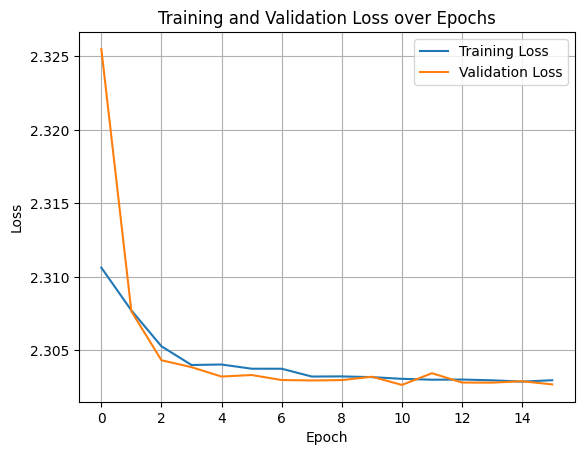

In [18]:
# GRÁFICO DE PÉRDIDAS
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]


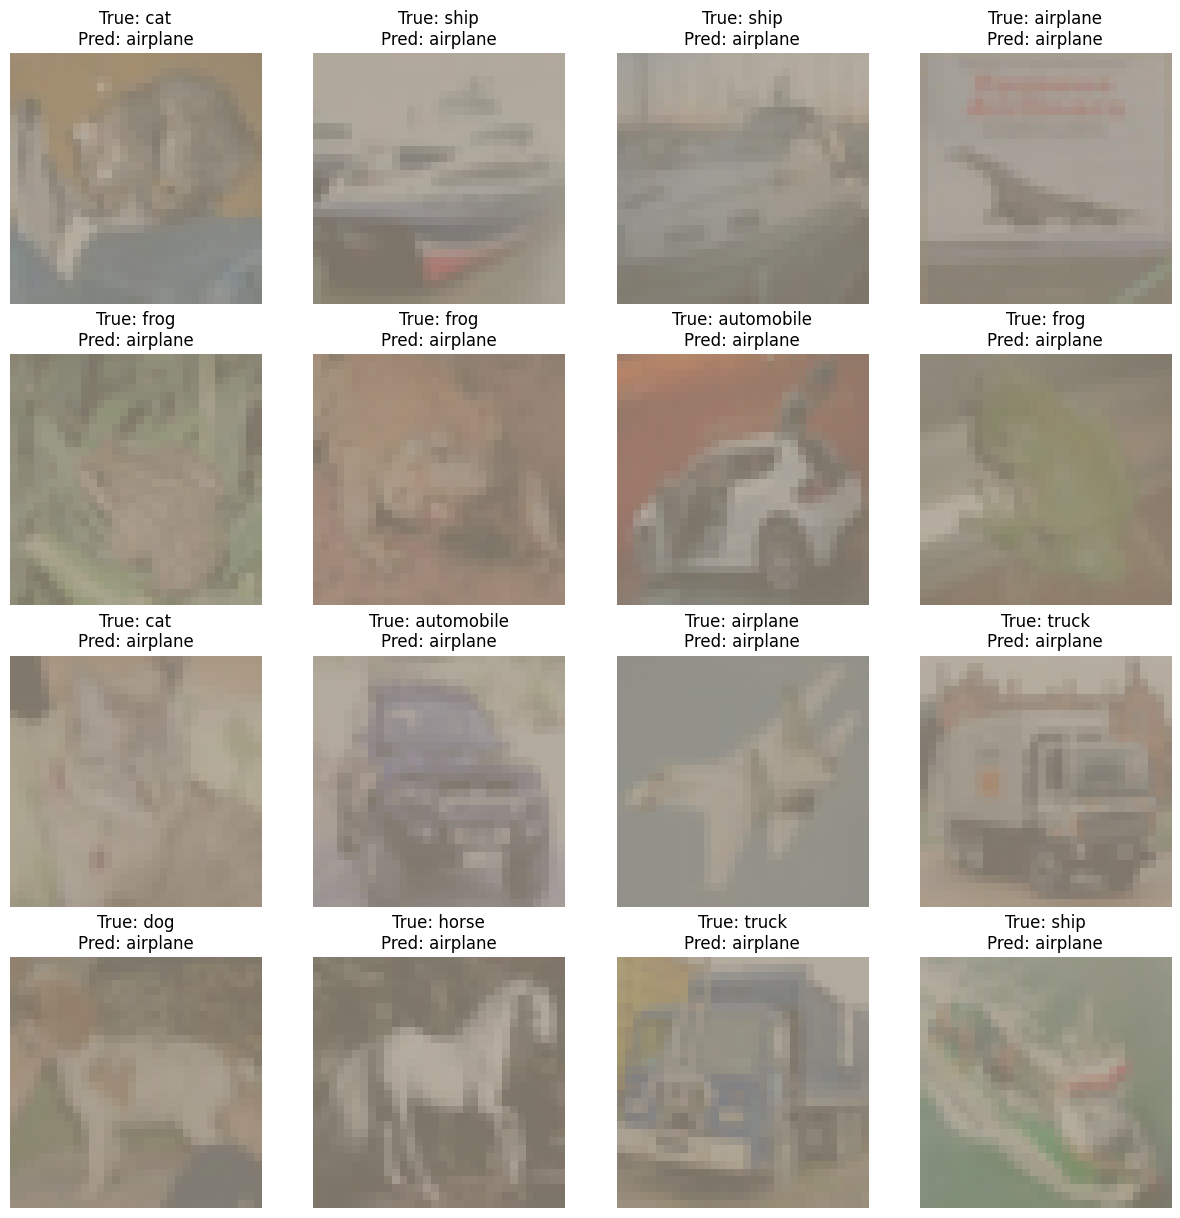

In [20]:
def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return

# Para CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

visualize_classification(model, test_loader, class_names, num_images=16)
plt.show()

# Resumen de lo que hicimos:
## Dataset:
* Usamos CIFAR-10 (torchvision.datasets.CIFAR10).
* Elegimos imágenes 32x32 (si hace falta, las podríamos agrandar a 64x64).

## Implementación de Vision Transformer Mini versión:
* patch_size = 4 (sobre imágenes de 32x32, 64 parches).
* embed_dim = 128.
* num_heads = 4.
* depth = 6 capas Transformer encoder.
* mlp_dim = 256 (en el MLP del encoder).
* Output: 10 clases (porque CIFAR-10 tiene 10 clases).

## Data Augmentation:
* Clásico: RandomCrop, RandomHorizontalFlip, ColorJitter.
* Extra: Mixup y CutMix (son un poco más complejos).

## Entrenamiento:
* Usamos el Trainer de la cátedra (trainer.py).
* Métricas: pérdida de entrenamiento y validación.
* Patience = 5 en EarlyStopping.
Learning Rate = 1e-3 con AdamW.
Batch size = 64.
Epochs máximo = 30 (frenó a las 16).
Data Augmentation mixto al azar.

# Visualizaciones:
* Curvas de pérdida (loss vs epochs).
* Ejemplos de imágenes aumentadas.